In [24]:
## Basic stuff
%load_ext autoreload
%autoreload
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>div.output_area{max-height:10000px;overflow:scroll;}</style>"""))

## Python Version
import sys
print("Python: {0}".format(sys.version))

from combine import combine
from fsUtils import moveFile
from ioUtils import getFile, saveFile
from timeUtils import clock, elapsed
from pandas import DataFrame, Series, read_csv


import datetime as dt
start = dt.datetime.now()
print("Notebook Last Run Initiated: "+str(start))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Python: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Notebook Last Run Initiated: 2019-11-06 22:31:03.733712


# Load Data

In [2]:
load = True
if load is False:
    names_basics = read_csv("imdb/name.basics.tsv", sep='\t')
    names = names_basics[["nconst", "primaryName"]]
    names.columns = ['nconst', 'Actor']
    saveFile(idata=names, ifile="imdb/names.p")
else:
    names = getFile("imdb/names.p")
names.head()

,nconst,Actor
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


In [3]:
load = True
if load is False:
    title_basics = read_csv("imdb/title.basics.tsv", sep='\t')
    print(title_basics.shape)
    titles = title_basics[title_basics["titleType"].isin(["movie"])][["tconst", "primaryTitle", "startYear"]]
    print(titles.shape)
    titles.columns = ["tconst", "Title", "Year"]
    saveFile(idata=titles, ifile="imdb/titles.p")
else:
    titles = getFile("imdb/titles.p", debug=True)
titles.head()

Loading data from imdb/titles.p
  --> This file is 21.3MB.
Loading imdb/titles.p


,tconst,Title,Year
8,tt0000009,Miss Jerry,1894
145,tt0000147,The Corbett-Fitzsimmons Fight,1897
332,tt0000335,Soldiers of the Cross,1900
499,tt0000502,Bohemios,1905
571,tt0000574,The Story of the Kelly Gang,1906


In [26]:
load = True
if load is False:
    title_principals = read_csv("imdb/title.principals.tsv", sep='\t')
    print(title_principals.shape)
    nameTitleMap = title_principals[title_principals['category'].isin(['actor', 'actress'])][["tconst", "nconst"]]
    print(nameTitleMap.shape)
    nameTitleMap = nameTitleMap[nameTitleMap['tconst'].isin(titles['tconst'])]
    print(nameTitleMap.shape)
    saveFile(idata=nameTitleMap, ifile="imdb/nameTitleMap.p")
else:
    nameTitleMap = getFile("imdb/nameTitleMap.p", debug=True)
nameTitleMap.head()
#1691205

Loading data from imdb/nameTitleMap.p
  --> This file is 27.1MB.
Loading imdb/nameTitleMap.p


,tconst,nconst
24,tt0000009,nm0063086
25,tt0000009,nm0183823
26,tt0000009,nm1309758
531,tt0000335,nm1010955
532,tt0000335,nm1012612


In [27]:
awards = getFile("awards/films.p")
df = DataFrame(Series(awards))
df.reset_index(inplace=True)
df.columns = ["MovieKey", "Award"]

tmp = df["MovieKey"].str.split("[", n=2, expand=True)
df["Movie"]  = tmp[0]
df["tconst"] = tmp[1].str[:-2]
df["Year"]   = tmp[2].str[:-1]
awards = df[["tconst", "Award"]]
awards.head()

,tconst,Award
0,tt0019071,0
1,tt0019553,0
2,tt0018253,0
3,tt0019217,0
4,tt0018379,0


## Get List of Movies To Source

In [28]:
print(nameTitleMap.shape)
tmp = nameTitleMap[nameTitleMap['tconst'].isin(awards['tconst'])]
print(tmp.shape)

print(nameTitleMap.shape)
print(tmp.shape)
nameTitleUsefulMap = nameTitleMap[nameTitleMap['nconst'].isin(tmp['nconst'])]
print(nameTitleUsefulMap.shape)
nameTitleUsefulMap.head()

(1691205, 2)
(24452, 2)
(1691205, 2)
(24452, 2)
(175270, 2)


,tconst,nconst
4245,tt0001115,nm0539049
4254,tt0001116,nm0539049
4853,tt0001230,nm0002503
6110,tt0001440,nm0539049
6119,tt0001440,nm0332028


In [29]:
print(nameTitleUsefulMap.shape)
nameTitleUsefulMap = nameTitleUsefulMap.merge(awards, on='tconst', how='left')
print(nameTitleUsefulMap.shape)
tmp = nameTitleUsefulMap.merge(titles, on='tconst', how='left')
print(tmp.shape)
networkMap = tmp.merge(names, on='nconst', how='left')
print(networkMap.shape)
networkDF = networkMap[["Title", "Actor", "Year", "Award"]]
vc = networkDF['Title'].value_counts()
singles = vc[vc == 1].index
networkDF = networkDF[~networkDF["Title"].isin(singles)]
networkDF["Year"] = networkDF["Year"].astype('int64', errors='ignore')
saveFile(idata=networkDF, ifile="network/data.p")
networkDF.head()

(175270, 2)
(175314, 3)
(175314, 5)
(175314, 6)


,Title,Actor,Year,Award
3,Valdemar Sejr,Peter Malberg,1910,NaN
4,Valdemar Sejr,Ellen Gottschalch,1910,NaN
7,Ekspeditricen,Clara Pontoppidan,1911,NaN
8,Ekspeditricen,Thorkild Roose,1911,NaN
11,Par habitude,Maurice Chevalier,1911,NaN


In [32]:
from fsUtils import mkDir
mkDir('network')
saveFile(idata=networkDF, ifile="network/data.p")

  --> This file is 2.6MB.


# Load Network Data

In [33]:
networkDF = getFile("network/data.p")

In [18]:
from itertools import combinations
import networkx as nx
nxG = nx.Graph()
print(networkDF.shape)
#limNetworkDF = networkDF[(networkDF['Award'] < 10) & (networkDF["Year"] > 2010)]
limNetworkDF = networkDF[(networkDF["Year"] > 2010)]
print(limNetworkDF.shape)
for movie, df in limNetworkDF.groupby('Key'):
    people  = df["Actor"].tolist()
    mapping = list(combinations(people, 2))
    nxG.add_edges_from(mapping, label=movie)
print(len(nxG.nodes()))
print(len(nxG.edges()))

(137364, 4)


TypeError: '>' not supported between instances of 'str' and 'int'

In [391]:
#remove = [node for node,degree in dict(G.degree()).items() if degree < 2]
print(len(nxG.nodes()))
nxG.remove_nodes_from(removeNodes)
print(len(nxG.nodes()))

2531
469


In [415]:
s = Series([len(x) for x in pyG.get_adj_list()])

In [420]:
s.quantile(0.75)

15.0

In [466]:
from pyvis import network as net
#Network(, bgcolor="#222222", font_color="white")
pyG = net.Network(height="850px", width="75%")
pyG.from_nx(nxG)

neighbor_map = pyG.get_adj_list()
s = Series([len(x) for x in neighbor_map])
from numpy import log1p, tanh
degrees      = nxG.degree()
for node in pyG.nodes:
    node["title"] += " Degree   :{0}<br>".format(degrees[node['id']])
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    #node["value"] = log1p(len(neighbor_map[node["id"]]))/10.0
    node["size"]  = 25*tanh(len(neighbor_map[node["id"]])/(s.quantile(0.75)))
    node["shape"] = "dot"
    node["mass"]  = node["size"]/10

pyG.show_buttons(filter_=['physics'])
options = """var options = {
    "nodes": {
      "borderWidth": 2,
      "borderWidthSelected": 1,
      "color": {
        "background": "rgba(108,247,252,1)",
        "highlight": {
          "border": "rgba(76,99,229,0.87)",
          "background": "rgba(255,75,206,1)"
        }
      },
      "shadow": {
        "enabled": true
      },
      "font": {
        "size": 10
      }
    },
    "configure": {
        "enabled": true,
        "filter": [
            "physics"
        ]
    },
    "edges": {
        "color": {
            "inherit": true
        },
        "width": 0.2,
        "smooth": {
            "enabled": false,
            "type": "continuous"
        }
    },
    "interaction": {
        "dragNodes": true,
        "hideEdgesOnDrag": false,
        "hideNodesOnDrag": false
    },
    "physics": {
        "enabled": true,
        "stabilization": {
            "enabled": true,
            "fit": true,
            "iterations": 1000,
            "onlyDynamicEdges": false,
            "updateInterval": 50
        }
    }
}"""
pyG.set_options(options)
pyG.show("mygraph.html")
print("Wrote it")

Wrote it


In [439]:
{'from': 'Gérard Depardieu', 'to': 'Glenn Close'}

TypeError: list indices must be integers or slices, not dict

In [348]:
x1 = nx.average_degree_connectivity(nxG)
x2 = nx.k_nearest_neighbors(nxG)
x3 = nx.average_neighbor_degree(nxG)

In [366]:
sbc = Series(nx.betweenness_centrality(nxG))
removeNodes = list(sbc[sbc == 0].index)
len(removeNodes)

2062

In [369]:
len(nxG.nodes())

2531

In [379]:
nxG.degree()["Brad Pitt"]

21

In [331]:
# draw
draw_graph3(G)

In [308]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False):
    """
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
        
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
        
    
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
    """
    
    # import
    from pyvis import network as net
    
    # make a pyvis network
    pyvis_graph = net.Network(notebook=notebook)
    
    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)
        
    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()
    
    # return and also save
    return pyvis_graph.show(output_filename)


##
# For example:
##

# make a new neworkx network
#import networkx as nx
#G=nx.Graph()

# add nodes and edges (color can be html color name or hex code)
##G.add_node('a',color='red',size=4)
#G.add_node('b',color='#30a1a5',size=3)
#G.add_node('c',color='green',size=1)
#G.add_edge('a','b',weight=1023)
#G.add_edge('a','c',weight=435)
#G.add_edge('b','c',weight=100)



/anaconda3/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


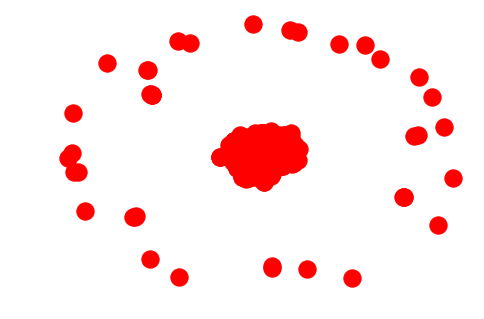

In [305]:
pos = nx.spring_layout(G)
nx.draw(G, pos) #, with_labels=True, font_weight='bold')
#edge_labels=dict([((u, v,), d['label']) for u, v, d in G.edges(data=True)])
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
#nx.draw

layoutname="rt_circular"
g = G
layout = g.layout(layoutname)
bbox = [0.5*x for x in (1000,1000)]

    fname = "plots/{0}/network_Len{1}_{2}.png".format(device, prec, layoutname)
    igplot = ig.plot(g, bbox=bbox, background="white", **visual_style) #, layout = layout)
    print("   ---> Saving {0}".format(fname))
    igplot.save(fname)

In [267]:
G.edges

EdgeView([('Tobias Engel', 'Sunnyi Melles'), ('Tobias Engel', 'Heinz Trixner'), ('Tobias Engel', 'Romuald Pekny'), ('Sunnyi Melles', 'Heinz Trixner'), ('Sunnyi Melles', 'Romuald Pekny'), ('Heinz Trixner', 'Romuald Pekny')])

,Movie,Actor
0,The Last Command [1929],Emil Jannings
1,The Way of All Flesh [1929],Emil Jannings
2,The Patriot [1930],Emil Jannings
3,The Last Command [1929],Evelyn Brent
4,Underworld [1929],Evelyn Brent
5,The Last Command [1929],William Powell
6,One Way Passage [1934],William Powell
7,The Thin Man [1935],William Powell
8,Manhattan Melodrama [1935],William Powell
9,My Man Godfrey [1937],William Powell


In [145]:
actorstitles = title_principles.merge(names, on=['nconst'], how='left')
actorsmovies = actorstitles.merge(movies, on=['tconst'], how='left')

In [147]:
actorsmovies.head()

,tconst,ordering,nconst,category,job,characters,primaryName,primaryTitle,startYear
0,tt0000001,1,nm1588970,self,\N,"[""Herself""]",Carmencita,NaN,NaN
1,tt0000005,1,nm0443482,actor,\N,"[""Blacksmith""]",Charles Kayser,NaN,NaN
2,tt0000005,2,nm0653042,actor,\N,"[""Assistant""]",John Ott,NaN,NaN
3,tt0000007,1,nm0179163,actor,\N,\N,James J. Corbett,NaN,NaN
4,tt0000007,2,nm0183947,actor,\N,\N,Peter Courtney,NaN,NaN


In [52]:
namestitles['key'] = namestitles[["primaryTitle", "startYear"]].apply(lambda x: "{0} [{1}]".format(x[0], x[1]), axis=1)

In [54]:
namestitles.index = namestitles['key']

In [65]:
namestitles.tail()

,tconst,ordering,nconst,category,job,characters,primaryTitle,startYear,primaryName,key
key,,,,,,,,,,
Horrid Henry Knows It All [2014],tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",Horrid Henry Knows It All,2014,Aidan Cook,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]",Horrid Henry Knows It All,2014,Sue Elliott-Nichols,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]",Horrid Henry Knows It All,2014,Wayne Forester,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,4,nm1052583,actress,\N,"[""Mum"",""Tidy Ted"",""Fang""]",Horrid Henry Knows It All,2014,Tamsin Heatley,Horrid Henry Knows It All [2014]
Horrid Henry Knows It All [2014],tt9916880,9,nm2676923,actress,\N,"[""Sour Susan"",""Goody-Goody Gordon"",""Singing So...",Horrid Henry Knows It All,2014,Joanna Ruiz,Horrid Henry Knows It All [2014]


In [224]:
awards

,Movie,tconst,Year
The Last Command [tt0019071] [1929],The Last Command,tt0019071,1929
The Way of All Flesh [tt0019553] [1929],The Way of All Flesh,tt0019553,1929
The Patent Leather Kid [tt0018253] [1929],The Patent Leather Kid,tt0018253,1929
The Noose [tt0019217] [1929],The Noose,tt0019217,1929
7th Heaven [tt0018379] [1929],7th Heaven,tt0018379,1929
Street Angel [tt0019429] [1929],Street Angel,tt0019429,1929
Sunrise [tt0018455] [1929],Sunrise,tt0018455,1929
Sadie Thompson [tt0019344] [1929],Sadie Thompson,tt0019344,1929
A Ship Comes In [tt0018389] [1929],A Ship Comes In,tt0018389,1929
Tempest [tt0019451] [1929],Tempest,tt0019451,1929


In [140]:
awards = getFile("awards/films.p")

films = DataFrame([[x[:-7] for x in dict(awards).keys()], [int(x[-5:-1]) for x in dict(awards).keys()]]).T
films.columns = ["primaryTitle", "startYear"]
films.index = films[["primaryTitle", "startYear"]].apply(lambda x: "{0} [{1}]".format(x[0], x[1]), axis=1)
films['Award'] = True
print(films.shape)
films = films[films['startYear'] > 2010]
#films.drop(["primaryTitle", "startYear"], axis=1, inplace=True)
print(films.shape)
films.head()

(7211, 3)
(1386, 3)


,primaryTitle,startYear,Award
The King's Speech [2011],The King's Speech,2011,True
127 Hours [2011],127 Hours,2011,True
Black Swan [2011],Black Swan,2011,True
Inception [2011],Inception,2011,True
The Fighter [2011],The Fighter,2011,True


In [56]:
## Match

In [124]:
possibles = movies[abs(movies['startYear'] - year) <= 2]
possibles.shape

(54173, 3)

In [135]:
Series(matches)

0                            [The King's Speech [2010]]
1                                    [127 Hours [2010]]
2                                   [Black Swan [2010]]
3                                    [Inception [2010]]
4                                  [The Fighter [2010]]
5                       [The Kids Are All Right [2010]]
6                           [The Social Network [2010]]
7                                  [Toy Story 3 [2010]]
8                                    [True Grit [2010]]
9                                [Winter's Bone [2010]]
10                                    [Biutiful [2010]]
11                              [Blue Valentine [2010]]
12                                 [Rabbit Hole [2010]]
13                                    [The Town [2012]]
14                              [Animal Kingdom [2010]]
15                                [Another Year [2010]]
16                         [Alice in Wonderland [2011]]
17    [Harry Potter and the Deathly Hallows: Par

In [153]:
for year,df in films.groupby('startYear'):
    possibles = movies[abs(movies['startYear'] - year) <= 2]
    print(year,df.shape,possibles.shape)
    
    matches = df.index.map(lambda x: difflib.get_close_matches(x, possibles.index, n=1, cutoff=0.9))
    films.loc[df.index, "Match"] = Series(matches, index=df.index).apply(lambda x: None if len(x) == 0 else x[0])
    
films.head()

2011 (137, 4) (65249, 3)
2012 (153, 4) (69912, 3)
2013 (152, 4) (74379, 3)
2014 (153, 4) (78936, 3)
2015 (153, 4) (82869, 3)
2016 (166, 4) (85404, 3)
2017 (166, 4) (83941, 3)
2018 (158, 4) (71437, 3)
2019 (148, 4) (54173, 3)


,primaryTitle,startYear,Award,tconst,Match
The King's Speech [2011],The King's Speech,2011,True,The King's Speech [2010],The King's Speech [2010]
127 Hours [2011],127 Hours,2011,True,127 Hours [2010],127 Hours [2010]
Black Swan [2011],Black Swan,2011,True,Black Swan [2010],Black Swan [2010]
Inception [2011],Inception,2011,True,Inception [2010],Inception [2010]
The Fighter [2011],The Fighter,2011,True,The Fighter [2010],The Fighter [2010]


,primaryTitle,startYear,Award,Match
The King's Speech [2011],The King's Speech,2011,True,The King's Speech [2010]
127 Hours [2011],127 Hours,2011,True,127 Hours [2010]
Black Swan [2011],Black Swan,2011,True,Black Swan [2010]
Inception [2011],Inception,2011,True,Inception [2010]
The Fighter [2011],The Fighter,2011,True,The Fighter [2010]


In [157]:
movieDB = movies.copy()
movieDB.reset_index(inplace=True)
movieDB = movieDB[["index", "tconst"]]
movieDB.columns=["Match", "tconst"]

,Match,tconst
0,The Other Side of the Wind [2018],tt0069049
1,Sabse Bada Sukh [2018],tt0069204
2,Devil Fetus [2019],tt0085953
3,The Wandering Soap Opera [2017],tt0100275
4,A Thin Life [2018],tt0111414


In [173]:
tmp = movieDB.merge(films, on="Match", how='left')
matchedMovies = tmp[~tmp['Award'].isna()]
tmp = title_principles.merge(matchedMovies, on=['tconst'], how='right')
print(tmp.shape)
tmp2 = tmp.merge(names, on=['nconst'], how='left')
print(tmp2.shape)
finalDB = tmp2[["primaryName", "primaryTitle", "startYear"]]
finalDB = finalDB[~finalDB["primaryName"].isna()]
finalDB = finalDB[~finalDB["primaryTitle"].isna()]

(4280, 7)
(4280, 8)


In [176]:
finalDB[finalDB["primaryTitle"] == "The Girl on the Train"]

,primaryName,primaryTitle,startYear
4179,Samantha Womack,The Girl on the Train,2017
4180,Matt Concannon,The Girl on the Train,2017
4181,John Dougall,The Girl on the Train,2017
4182,Oliver Farnworth,The Girl on the Train,2017
4183,Phillipa Flynn,The Girl on the Train,2017
4184,Naeem Hayat,The Girl on the Train,2017
4185,Adam Jackson-Smith,The Girl on the Train,2017
4186,Lowenna Melrose,The Girl on the Train,2017
4187,Kirsty Oswald,The Girl on the Train,2017


(4280, 7)
(4280, 8)


In [170]:
tmp2

,tconst,nconst,category,Match,primaryTitle,startYear,Award,primaryName
0,tt0369610,nm0695435,actor,Jurassic World [2015],Jurassic World,2016,True,Chris Pratt
1,tt0369610,nm0397171,actress,Jurassic World [2015],Jurassic World,2016,True,Bryce Dallas Howard
2,tt0369610,nm1339223,actor,Jurassic World [2015],Jurassic World,2016,True,Ty Simpkins
3,tt0369610,nm0339460,actress,Jurassic World [2015],Jurassic World,2016,True,Judy Greer
4,tt0409847,nm0185819,actor,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Daniel Craig
5,tt0409847,nm0000148,actor,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Harrison Ford
6,tt0409847,nm1312575,actress,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Olivia Wilde
7,tt0409847,nm0817844,actress,Cowboys & Aliens [2011],Cowboys & Aliens,2012,True,Abigail Spencer
8,tt0420293,nm3009232,actor,The Stanford Prison Experiment [2015],The Stanford Prison Experiment,2015,True,Ezra Miller
9,tt0420293,nm4446467,actor,The Stanford Prison Experiment [2015],The Stanford Prison Experiment,2015,True,Tye Sheridan


In [114]:
matches = films.index.map(lambda x: difflib.get_close_matches(x, movies.index, n=1, cutoff=0.9))
films["match"] = Series(matches, index=films.index).apply(lambda x: None if len(x) == 0 else x[0])

In [115]:
films

,Award,match
The King's Speech [2011],True,The King's Speech [2010]
127 Hours [2011],True,127 Hours [2010]
Black Swan [2011],True,Black Swan [2010]
Inception [2011],True,Inception [2010]
The Fighter [2011],True,The Fighter [2010]
The Kids Are All Right [2011],True,The Kids Are All Right [2010]
The Social Network [2011],True,The Social Network [2010]
Toy Story 3 [2011],True,Toy Story 3 [2010]
True Grit [2011],True,True Grit [2010]
Winter's Bone [2011],True,Winter's Bone [2010]


In [63]:
matches = namestitles.index.map(lambda x: difflib.get_close_matches(x, films.index, n=1, cutoff=0.95))
namestitles["match"] = matches.apply(lambda x: None if len(x) == 0 else x[0])

KeyboardInterrupt: 

In [ ]:
namestitles["match"] = matches.apply(lambda x: None if len(x) == 0 else x[0])

In [45]:
awardsFilms = films.sort_values(by="primaryTitle")

In [49]:
namestitles.merge(awardsFilms, on=['primaryTitle'], how='inner')

,tconst,ordering,nconst,category,job,characters,primaryTitle,startYear_x,primaryName,startYear_y
0,tt0000181,1,nm0809419,actress,\N,"[""Cinderella""]",Cinderella,1898,Laura Bayley,2016
1,tt0000230,1,nm1333156,actress,\N,"[""Cinderella""]",Cinderella,1899,Mlle Barral,2016
2,tt0000230,2,nm0076933,actress,\N,"[""The Fairy Godmother""]",Cinderella,1899,Bleuette Bernon,2016
3,tt0000230,3,nm1778224,actor,\N,"[""Prince Charming""]",Cinderella,1899,Carmelli,2016
4,tt0000230,4,nm0194945,actress,\N,"[""Fairy Godmother""]",Cinderella,1899,Jehanne d'Alcy,2016
5,tt0000230,7,nm1778292,actor,\N,"[""Party Guest""]",Cinderella,1899,Dupeyron,2016
6,tt0001545,1,nm0478359,actress,\N,"[""Cinderella""]",Cinderella,1911,Florence La Badie,2016
7,tt0001545,2,nm0071132,actor,\N,"[""The Prince""]",Cinderella,1911,Harry Benham,2016
8,tt0001545,3,nm0741884,actress,\N,\N,Cinderella,1911,Anna Rosemond,2016
9,tt0001545,4,nm0186345,actor,\N,\N,Cinderella,1911,Frank Hall Crane,2016
